# Introduction guide to `contextily`

Welcome to the taster guide for `contextily`, the package for contextual tiles in Python. In this notebook, we will show the basic functionality available in `contextily`, a package to work with web-tiles for background maps. To do that, we will use additional data to illustrate `contextily` can be integrated with other libraries such as `geopandas` and `rasterio`.

In [1]:
%matplotlib inline

import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

In this guide, we will use a delineation of urban areas in Spain proposed by [Arribas-Bel,  Garcia-Lopez & Viladecans-Marsal (2019)](https://www.sciencedirect.com/science/article/abs/pii/S0094119019300944) and available from:

In [2]:
data_url = "https://ndownloader.figshare.com/files/20232174"

We car read it straight away:

In [3]:
db = geopandas.read_file(data_url)

## TL;DR

The simplest way to access `contextily` and get a background map to go with your geographic data is to use the `add_basemap` method. Because the method takes a `matplotlib` axis, it is easy to integrate `contextily` with any other package for geospatial data that plots to `matplotlib` (e.g. `rasterio`, `geopandas`, etc.).

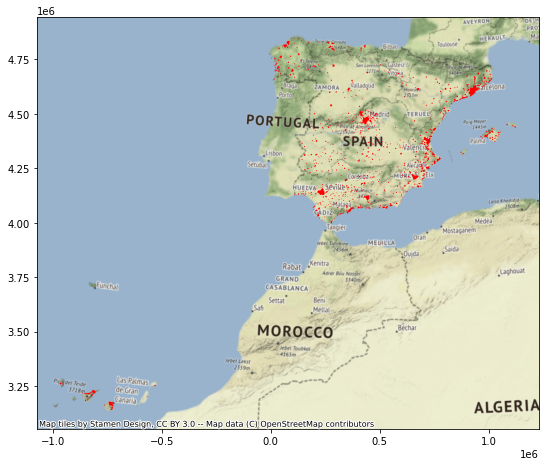

In [4]:
ax = db.plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=db.crs.to_string())

## Providers

There is a whole host of providers, so you can switch easily between backgrounds:

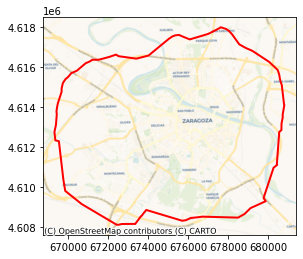

In [5]:
zaragoza = db.query("city_id == 'ci122'")
ax = zaragoza.plot(facecolor="none", 
                   edgecolor="red",
                   linewidth=2
                  )
cx.add_basemap(ax, 
               crs=zaragoza.crs.to_string(), 
               source=cx.providers.CartoDB.Voyager
              )

They are stored as dictionaries, so you can explore them within Python:

In [6]:
cx.providers.keys()

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])

In [7]:
cx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])

And it is all based on standard XYZ tile protocol, so if you have your own tile service that follows it, you can use it too!

## Coordinate-based searches

Additional shapes are not required to access tiles. As long as you have a bounding box of coordinates, you can access tiles. This bounding box needs to be expressed either in Web (Spherical) Mercator or in longitude and latitude (WGS84).

For example, let's grab the bounding box for Ghent (Belgium):

In [8]:
west, south, east, north = (
    3.616218566894531,
    50.98912458110244,
    3.8483047485351562,
    51.13994019806845
             )

To download tiles, we can use `bounds2img`:

In [9]:
ghent_img, ghent_ext = cx.bounds2img(west, 
                                     south, 
                                     east, 
                                     north, 
                                     ll=True, 
                                     source=cx.providers.Stamen.Toner
                                    )

This returns a three-dimensional array with the image colors:

In [10]:
ghent_img.shape

(1536, 1536, 4)

And the extent of the basemap downloaded (in Web Mercator):

In [11]:
ghent_ext

(401141.5244406049, 430493.34330211265, 6618835.153269979, 6648186.972131489)

With these two bits of information, we can render it on `matplotlib`:

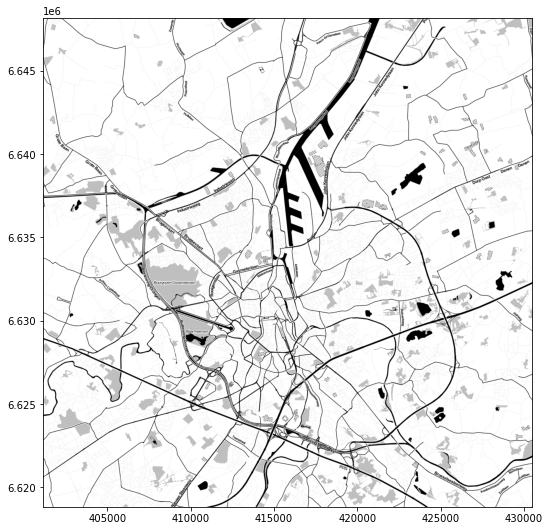

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(ghent_img, extent=ghent_ext)

## Places

You can also access tiles of places with a text-based search, and `contextily` will do its best to find you a solution (this functionality is thanks to [`geopy`](https://geopy.readthedocs.io/en/stable/), an amazing geocoding package, working under the hood):

In [13]:
nightlights = cx.providers.NASAGIBS.ViirsEarthAtNight2012
ireland = cx.Place("Ireland", source=nightlights)

Once acquired, plotting it is one command away:

<AxesSubplot:title={'center':'Éire / Ireland'}, xlabel='X', ylabel='Y'>

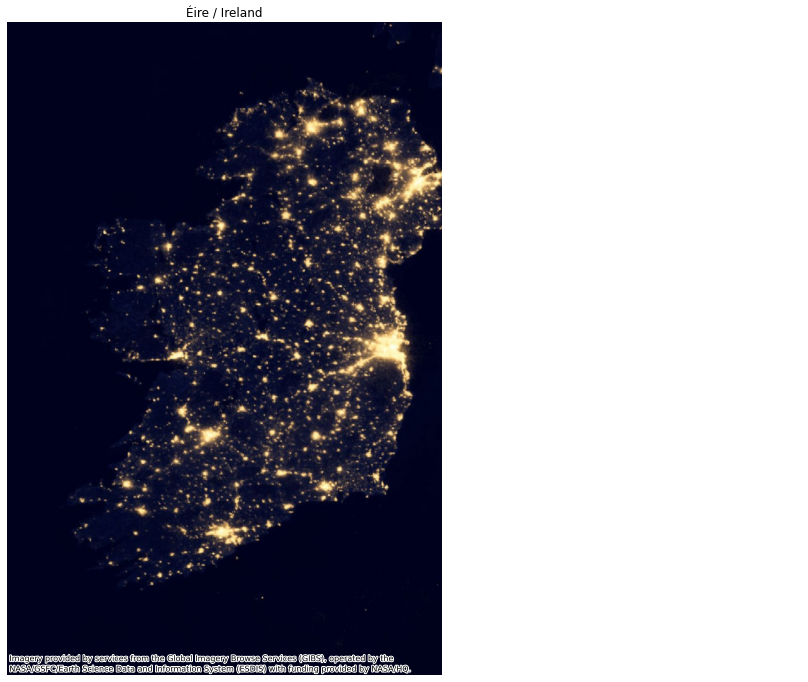

In [14]:
ireland.plot()

## Store basemaps locally

When you are working interactively, it is common to iterate over one visualisation several times and to have to combine several tools, not necessarily always Python. In these two situations, it is very handy if you don't have to re-download a basemap every new iteration. `contextily` helps you with both.

First, in a given session, each tile is only downloaded once. Tiles are stored in a temporary cache so the next time you need it, you don't have go to the web. This results in important time savings and network footprint.

In [15]:
%time tempe = cx.Place("Tempe, AZ")

CPU times: user 993 ms, sys: 110 ms, total: 1.1 s
Wall time: 4.38 s


In [16]:
%time tempe = cx.Place("Tempe, AZ")

CPU times: user 62.5 ms, sys: 21.1 ms, total: 83.7 ms
Wall time: 219 ms


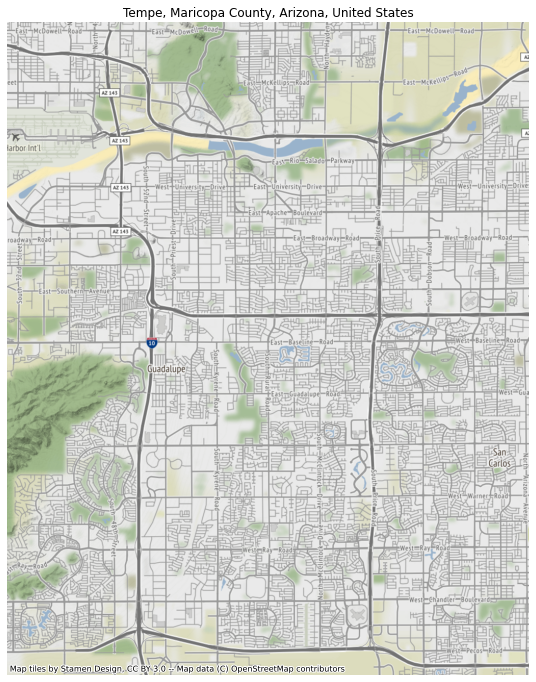

In [17]:
tempe.plot()

Second, `contextily` lets you download basemaps and store them in standard raster files that you can open back in Python, or in any other GIS. There are several ways to access this functionality. One is through the Places API:

In [18]:
bristol = cx.Place("Bristol, UK", path="bristol.tif")

this downloads a basemap for Bristol and saves it to a file called `bristol.tif`, which you can access, for example, with `rasterio`:

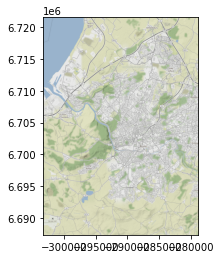

In [19]:
with rasterio.open("bristol.tif") as r:
    rioshow(r)

And you can also pull down basemaps using `bounds2img`'s sister method, `bounds2raster`, which works similarly:

In [20]:
w, s, e, n = (-3.0816650390625,
              53.268087670237485,
             -2.7582550048828125,
              53.486002749115556)
_ = cx.bounds2raster(w, s, e, n, 
                     ll=True, 
                     path="liverpool.tif",
                     source=cx.providers.CartoDB.Positron
                    )

And view it equally:

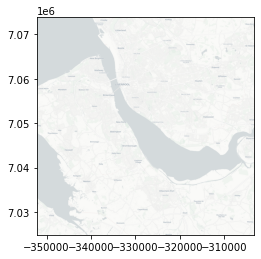

In [21]:
with rasterio.open("liverpool.tif") as r:
    rioshow(r)

## Fine tune zoom levels

Tile-based basemaps are provided at different zoom levels. Usually, `contextily` will automatically figure out an appropriate level so you don't have to think about it. But sometimes, a user might want to fiddle with zoom levels on her own. For these tasks, the `zoom` parameter will be your friend.

For example, let's return to the Ghent map:

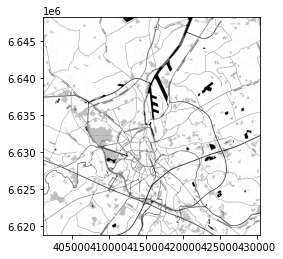

In [22]:
plt.imshow(ghent_img, extent=ghent_ext)

If we want a lower degree of resolution, maybe we can try level 10?

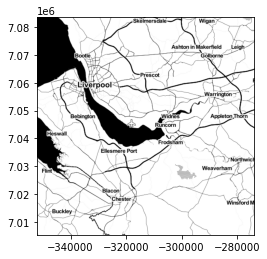

In [23]:
ghent_img, ghent_ext = cx.bounds2img(w, 
                                     s, 
                                     e, 
                                     n, 
                                     ll=True, 
                                     source=cx.providers.Stamen.Toner,
                                     zoom=10,
                                    )
plt.imshow(ghent_img, extent=ghent_ext)

If you want to peak into the automatic level calculated, you can do it:

In [24]:
cx.tile._calculate_zoom(w, s, e, n)

12

Higher levels of resolution for the same extent involve more tiles being downloaded, which may take longer, so keep this in mind if you "bump up" the resolution. To check how many tiles need to be downloaded, you can use this other utility:

In [25]:
cx.howmany(w, s, e, n, 13, ll=True)

Using zoom level 13, this will download 81 tiles


81

In [26]:
cx.howmany(w, s, e, n, 15, ll=True)

Using zoom level 15, this will download 1020 tiles


1020

In [27]:
cx.howmany(w, s, e, n, 10, ll=True)

Using zoom level 10, this will download 4 tiles


4

## Using transparent layers

Sometimes, when you plot data on a basemap, the data will obscure some important map elements,
such as labels, that you would otherwise want to see unobscured. 

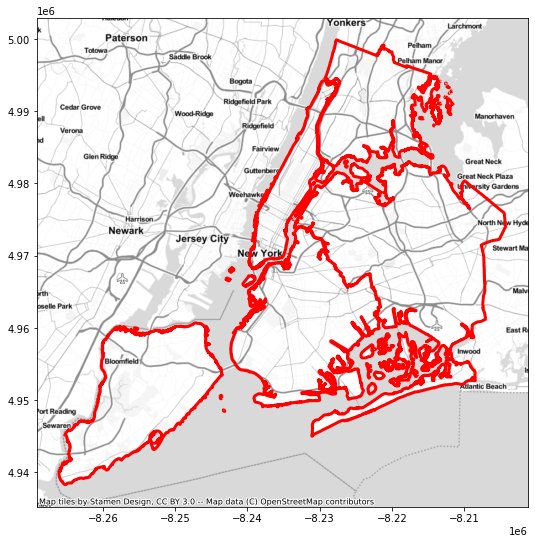

In [28]:
df = geopandas.read_file(geopandas.datasets.get_path('nybb')).to_crs(epsg=3857)
ax = df.plot(figsize=(9,9), color="none", edgecolor="r", linewidth=3)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.TonerLite)

Some map tile providers offer multiple sets of partially transparent tiles to solve this, and `contextily` will do its best to auto-detect these transparent layers and put them on top.

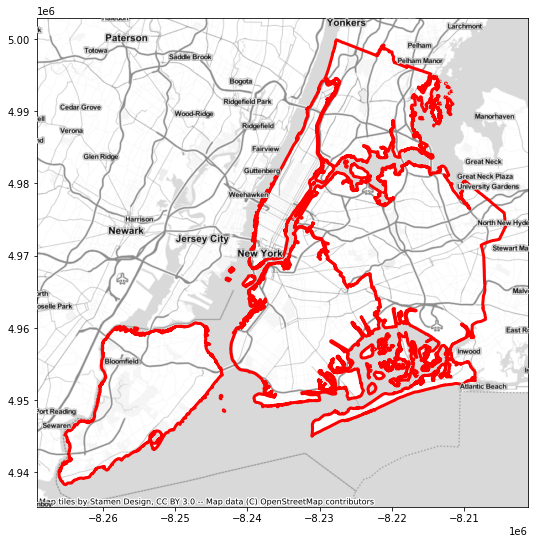

In [29]:
ax = df.plot(figsize=(9,9), color="none", edgecolor="r", linewidth=3)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.TonerLabels)

By splitting the layers like this, you can also independently manipulate the level of zoom
on each layer, for example to make labels larger while still showing a lot of detail.

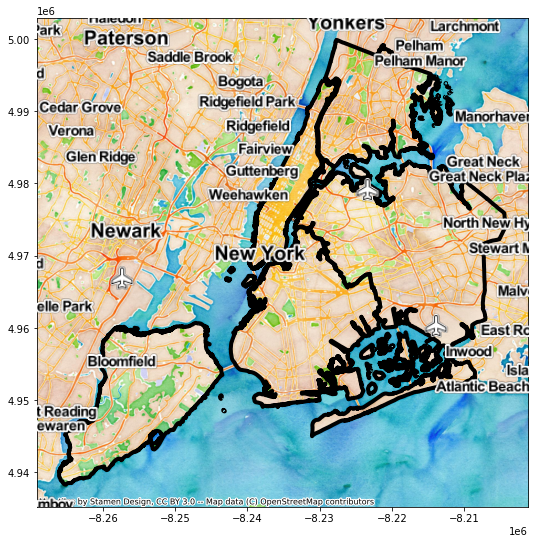

In [30]:
ax = df.plot(figsize=(9,9), color="none", edgecolor="k", linewidth=4)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.Watercolor, zoom=12)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.TonerLabels, zoom=10)